In [27]:
# Pehle MKDIR TEMPIMG karke directory bana

import tensorflow as tf
from tensorflow import keras

import glob
import os

from keras import Input
from keras.applications import VGG19
from keras.callbacks import TensorBoard
from keras.layers import BatchNormalization, Activation, LeakyReLU, Add, Dense
from keras.layers import Conv2D, UpSampling2D
from keras.models import Model
from keras.optimizers import Adam

import numpy as np

import random
from numpy import asarray
from itertools import repeat

import imageio
from imageio import imread
from PIL import Image
from skimage.transform import resize as imresize
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

print("Tensorflow version " + tf.__version__)
print("Keras version " + tf.keras.__version__)

# try:
#   tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
#   print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
# except ValueError:
#   raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

# tf.config.experimental_connect_to_cluster(tpu)
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Tensorflow version 2.1.0
Keras version 2.2.4-tf


In [2]:
!pip install keras==2.3.1
!pip install tensorflow==2.1.0

     |████████████████████████████████| 378kB 7.0MB/s 
     |████████████████████████████████| 51kB 4.4MB/s 
  Found existing installation: Keras 2.4.3
    Uninstalling Keras-2.4.3:
      Successfully uninstalled Keras-2.4.3


     |████████████████████████████████| 421.8MB 36kB/s 
     |████████████████████████████████| 3.9MB 22.3MB/s 
     |████████████████████████████████| 450kB 26.4MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp37-none-any.whl size=7540 sha256=214bb52ccc0fcd406fa442b2ab77474396597788bd923ea8c4d40163f745c0fb
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
ERROR: tensorflow-probability 0.12.1 has requirement gast>=0.3.2, but you'll have gast 0.2.2 which is incompatible.
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: 

In [49]:
# data path
TRAIN_PATH = r'/content/drive/MyDrive/SRCNN_Data/Final/Train'
# VAL_PATH = r'../input/kermany2018/OCT2017 /val/'
TEST_PATH = r'/content/drive/MyDrive/SRCNN_Data/Final/Test'
data_path = TRAIN_PATH

epochs = 5001

# batch size equals to 8 (due to RAM limits)
batch_size = 8

# define the shape of low resolution image (LR) 
low_resolution_shape = (64, 64, 3)

# define the shape of high resolution image (HR) 
high_resolution_shape = (256, 256, 3)

# optimizer for discriminator, generator 
common_optimizer = Adam(0.0002, 0.5)

# use seed for reproducible results
SEED = 2020 
tf.random.set_seed(SEED)

In [29]:
def get_train_images(data_path):

    # CLASSES = ['CNV', 'DME', 'DRUSEN', 'NORMAL']
    image_list = []

    image_list.extend(glob.glob(data_path +  '/*'))
    
    return image_list    


def find_img_dims(image_list):
    
    min_size = []
    max_size = []
    
    for i in range(len(image_list)):
        im = Image.open(image_list[i])
        min_size.append(min(im.size))
        max_size.append(max(im.size))
    
    return min(min_size), max(max_size)

In [30]:
image_list = get_train_images(data_path)
min_size, max_size = find_img_dims(image_list)
print('The min and max image dims are {} and {} respectively.'
      .format(min_size, max_size))

The min and max image dims are 145 and 727 respectively.


In [31]:
def compute_psnr(original_image, generated_image):
    
    original_image = tf.convert_to_tensor(original_image, dtype=tf.float32)
    generated_image = tf.convert_to_tensor(generated_image, dtype=tf.float32)
    psnr = tf.image.psnr(original_image, generated_image, max_val=1.0)

    return tf.math.reduce_mean(psnr, axis=None, keepdims=False, name=None)

In [32]:
def plot_psnr(psnr):
    
    psnr_means = psnr['psnr_quality']
    plt.figure(figsize=(10,8))
    plt.plot(psnr_means)    
    plt.xlabel('Epochs')
    plt.ylabel('PSNR') 
    plt.title('PSNR')

In [33]:
def compute_ssim(original_image, generated_image):
    
    original_image = tf.convert_to_tensor(original_image, dtype=tf.float32)
    generated_image = tf.convert_to_tensor(generated_image, dtype=tf.float32)
    ssim = tf.image.ssim(original_image, generated_image, max_val=1.0, filter_size=11,
                          filter_sigma=1.5, k1=0.01, k2=0.03)

    return tf.math.reduce_mean(ssim, axis=None, keepdims=False, name=None)

    
def plot_ssim(ssim):
    
    ssim_means = ssim['ssim_quality']

    plt.figure(figsize=(10,8))
    plt.plot(ssim_means)
    plt.xlabel('Epochs')
    plt.ylabel('SSIM')
    plt.title('SSIM')

In [34]:
def plot_loss(losses):

    d_loss = losses['d_history']
    g_loss = losses['g_history']
    
   
    plt.figure(figsize=(10,8))
    plt.plot(d_loss, label="Discriminator loss")
    plt.plot(g_loss, label="Generator loss")
    
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title("Loss")    
    plt.legend()

In [35]:
def sample_images(image_list, batch_size, high_resolution_shape, low_resolution_shape):
    
    """
    Pre-process a batch of training images
    """
    
    # image_list is the list of all images
    # ransom sample a batch of images
    images_batch = np.random.choice(image_list, size=batch_size)
    
    lr_images = []
    hr_images = []
    

    for img in images_batch:
  
        img1 = imread(img, as_gray=False, pilmode='RGB')
        #img1 = imread(img, pilmode='RGB')
        img1 = img1.astype(np.float32)
        
        # change the size     
        img1_high_resolution = imresize(img1, high_resolution_shape)
        img1_low_resolution = imresize(img1, low_resolution_shape)
                

        # do a random horizontal flip
        if np.random.random() < 0.5:
            img1_high_resolution = np.fliplr(img1_high_resolution)
            img1_low_resolution = np.fliplr(img1_low_resolution)
       
        hr_images.append(img1_high_resolution)
        lr_images.append(img1_low_resolution)
        
   
    # convert lists into numpy ndarrays
    return np.array(hr_images), np.array(lr_images)    

In [36]:
def save_images(original_image, lr_image, sr_image, path):
    
    """
    Save LR, HR (original) and generated SR
    images in one panel 
    """
    
    fig, ax = plt.subplots(1,3, figsize=(10, 6))

    images = [original_image, lr_image, sr_image]
    titles = ['HR', 'LR','SR - generated']

    for idx,img in enumerate(images):
        # (X + 1)/2 to scale back from [-1,1] to [0,1]
        ax[idx].imshow((img + 1)/2.0, cmap='gray')
        ax[idx].axis("off")
    for idx, title in enumerate(titles):    
        ax[idx].set_title('{}'.format(title))
        
    plt.savefig(path)    

In [37]:
def residual_block(x):

    filters = [64, 64]
    kernel_size = 3
    strides = 1
    padding = "same"
    momentum = 0.8
    activation = "relu"

    res = Conv2D(filters=filters[0], kernel_size=kernel_size, strides=strides, padding=padding)(x)
    res = Activation(activation=activation)(res)
    res = BatchNormalization(momentum=momentum)(res)

    res = Conv2D(filters=filters[1], kernel_size=kernel_size, strides=strides, padding=padding)(res)
    res = BatchNormalization(momentum=momentum)(res)

    res = Add()([res, x])
    
    return res

In [38]:
def build_generator():
    
    # use 16 residual blocks in generator
    residual_blocks = 16
    momentum = 0.8
    
    # input LR dimension: 4x downsample of HR
    input_shape = (64, 64, 3)
    
    # input for the generator
    input_layer = Input(shape=input_shape)
    
    # pre-residual block: conv layer before residual blocks 
    gen1 = Conv2D(filters=64, kernel_size=9, strides=1, padding='same', activation='relu')(input_layer)
    
    # add 16 residual blocks
    res = residual_block(gen1)
    for i in range(residual_blocks - 1):
        res = residual_block(res)
    
    # post-residual block: conv and batch-norm layer after residual blocks
    gen2 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(res)
    gen2 = BatchNormalization(momentum=momentum)(gen2)
    
    # take the sum of pre-residual block(gen1) and post-residual block(gen2)
    gen3 = Add()([gen2, gen1])
    
    # upsampling
    gen4 = UpSampling2D(size=2)(gen3)
    gen4 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(gen4)
    gen4 = Activation('relu')(gen4)
    
    # upsampling
    gen5 = UpSampling2D(size=2)(gen4)
    gen5 = Conv2D(filters=256, kernel_size=3, strides=1, padding='same')(gen5)
    gen5 = Activation('relu')(gen5)
    
    # conv layer at the output
    gen6 = Conv2D(filters=3, kernel_size=9, strides=1, padding='same')(gen5)
    output = Activation('tanh')(gen6)
    
    # model 
    model = Model(inputs=[input_layer], outputs=[output], name='generator')

    return model

In [39]:
generator = build_generator()

In [40]:
def build_discriminator():
    
    # define hyperparameters
    leakyrelu_alpha = 0.2
    momentum = 0.8
    
    # the input is the HR shape
    input_shape = (256, 256, 3)
    
    # input layer for discriminator
    input_layer = Input(shape=input_shape)
    
    # 8 convolutional layers with batch normalization  
    dis1 = Conv2D(filters=64, kernel_size=3, strides=1, padding='same')(input_layer)
    dis1 = LeakyReLU(alpha=leakyrelu_alpha)(dis1)

    dis2 = Conv2D(filters=64, kernel_size=3, strides=2, padding='same')(dis1)
    dis2 = LeakyReLU(alpha=leakyrelu_alpha)(dis2)
    dis2 = BatchNormalization(momentum=momentum)(dis2)

    dis3 = Conv2D(filters=128, kernel_size=3, strides=1, padding='same')(dis2)
    dis3 = LeakyReLU(alpha=leakyrelu_alpha)(dis3)
    dis3 = BatchNormalization(momentum=momentum)(dis3)

    dis4 = Conv2D(filters=128, kernel_size=3, strides=2, padding='same')(dis3)
    dis4 = LeakyReLU(alpha=leakyrelu_alpha)(dis4)
    dis4 = BatchNormalization(momentum=0.8)(dis4)

    dis5 = Conv2D(256, kernel_size=3, strides=1, padding='same')(dis4)
    dis5 = LeakyReLU(alpha=leakyrelu_alpha)(dis5)
    dis5 = BatchNormalization(momentum=momentum)(dis5)

    dis6 = Conv2D(filters=256, kernel_size=3, strides=2, padding='same')(dis5)
    dis6 = LeakyReLU(alpha=leakyrelu_alpha)(dis6)
    dis6 = BatchNormalization(momentum=momentum)(dis6)

    dis7 = Conv2D(filters=512, kernel_size=3, strides=1, padding='same')(dis6)
    dis7 = LeakyReLU(alpha=leakyrelu_alpha)(dis7)
    dis7 = BatchNormalization(momentum=momentum)(dis7)

    dis8 = Conv2D(filters=512, kernel_size=3, strides=2, padding='same')(dis7)
    dis8 = LeakyReLU(alpha=leakyrelu_alpha)(dis8)
    dis8 = BatchNormalization(momentum=momentum)(dis8)
    
    # fully connected layer 
    dis9 = Dense(units=1024)(dis8)
    dis9 = LeakyReLU(alpha=0.2)(dis9)
    
    # last fully connected layer - for classification 
    output = Dense(units=1, activation='sigmoid')(dis9)   
    
    model = Model(inputs=[input_layer], outputs=[output], name='discriminator')
    
    return model

In [41]:
discriminator = build_discriminator()
discriminator.trainable = True
discriminator.compile(loss='mse', optimizer=common_optimizer, metrics=['accuracy'])

In [42]:
VGG19_base = VGG19(weights="imagenet")

In [43]:
def build_VGG19():
    
    input_shape = (256, 256, 3)
    VGG19_base.outputs = [VGG19_base.get_layer('block5_conv2').output]
    input_layer = Input(shape=input_shape)
    features = VGG19_base(input_layer)
    model = Model(inputs=[input_layer], outputs=[features])
    
    return model

In [44]:
fe_model = build_VGG19()
fe_model.trainable = False
fe_model.compile(loss='mse', optimizer=common_optimizer, metrics=['accuracy'])

In [45]:
def build_adversarial_model(generator, discriminator, feature_extractor):
    
    # input layer for high-resolution images
    input_high_resolution = Input(shape=high_resolution_shape)

    # input layer for low-resolution images
    input_low_resolution = Input(shape=low_resolution_shape)

    # generate high-resolution images from low-resolution images
    generated_high_resolution_images = generator(input_low_resolution)

    # extract feature maps from generated images
    features = feature_extractor(generated_high_resolution_images)
    
    # make a discriminator non-trainable 
    discriminator.trainable = False
    discriminator.compile(loss='mse', optimizer=common_optimizer, metrics=['accuracy'])

    # discriminator will give us a probability estimation for the generated high-resolution images
    probs = discriminator(generated_high_resolution_images)

    # create and compile 
    adversarial_model = Model([input_low_resolution, input_high_resolution], [probs, features])
    adversarial_model.compile(loss=['binary_crossentropy', 'mse'], loss_weights=[1e-3, 1], optimizer=common_optimizer)
    
    return adversarial_model

In [46]:
adversarial_model = build_adversarial_model(generator, discriminator, fe_model)

In [47]:
# initialize 

losses = {"d_history":[], "g_history":[]}
psnr = {'psnr_quality': []}
ssim = {'ssim_quality': []}

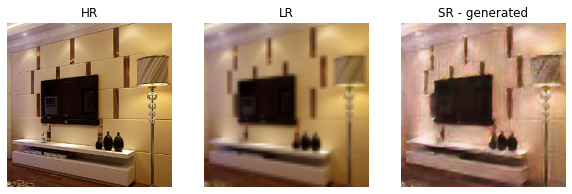

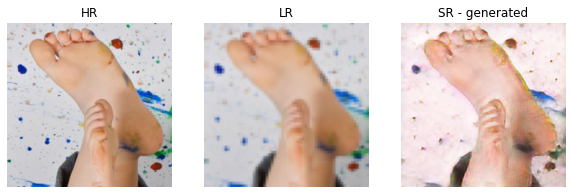

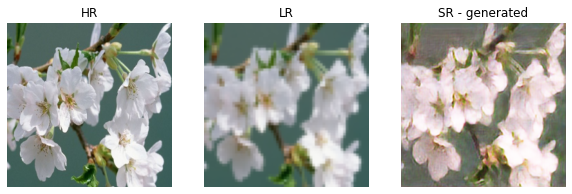

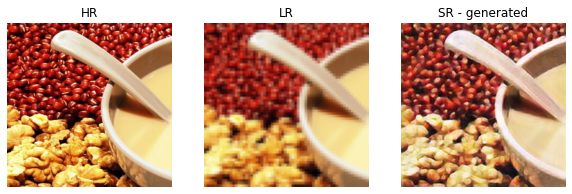

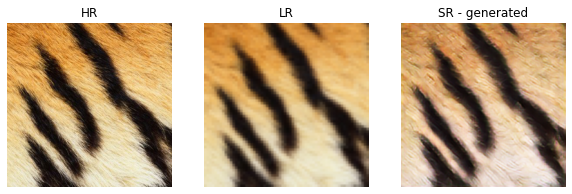

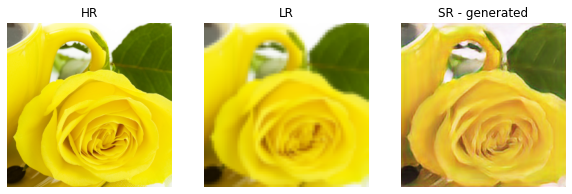

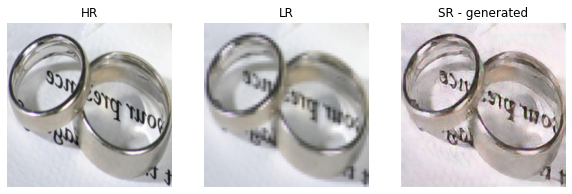

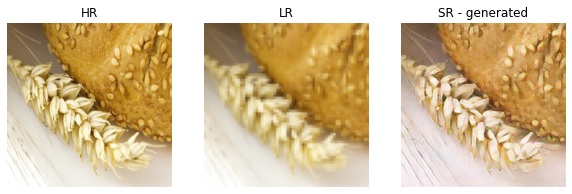

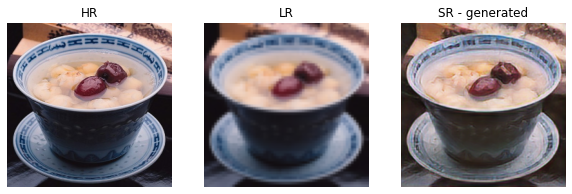

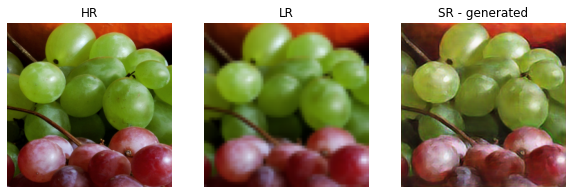

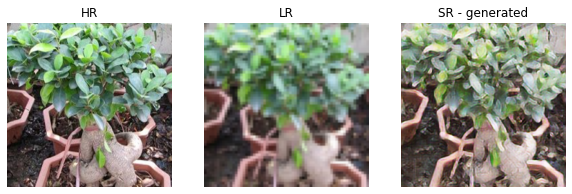

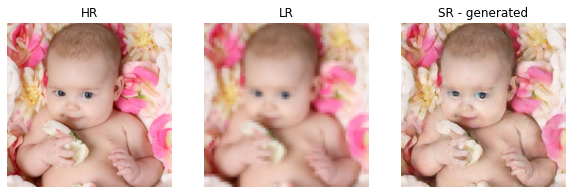

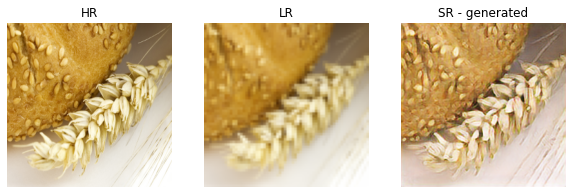

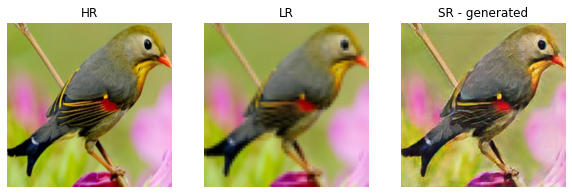

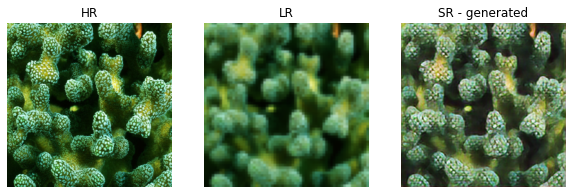

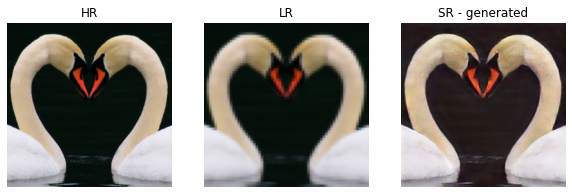

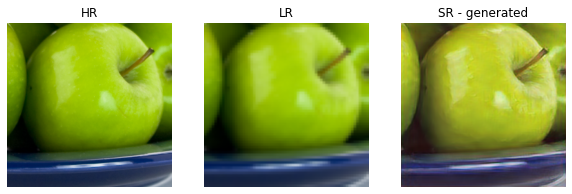

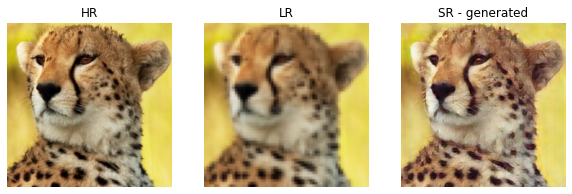

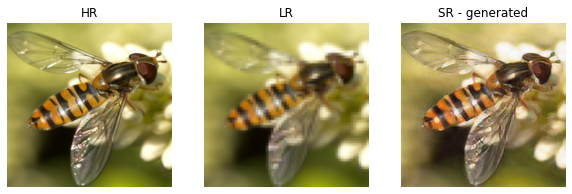

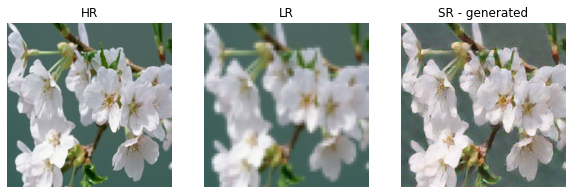

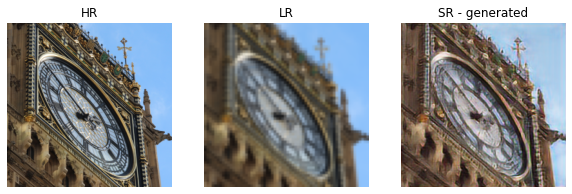

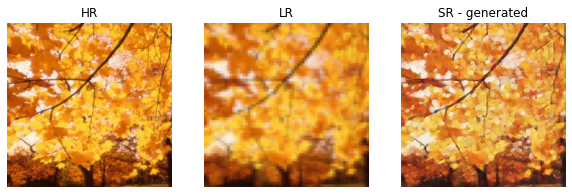

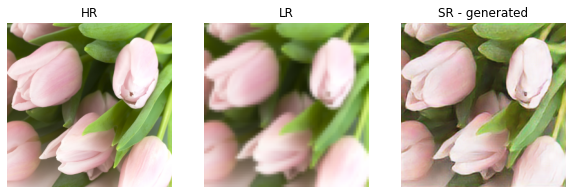

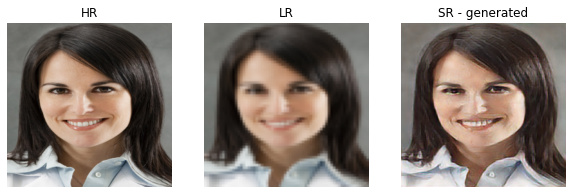

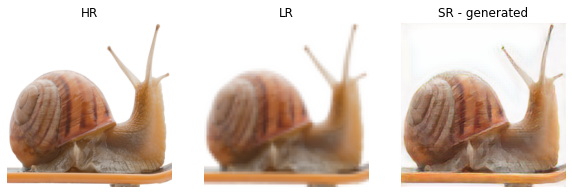

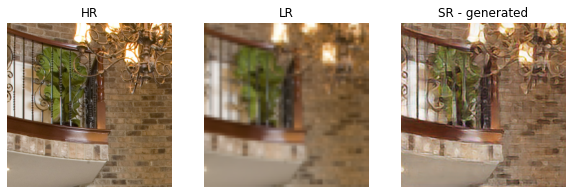

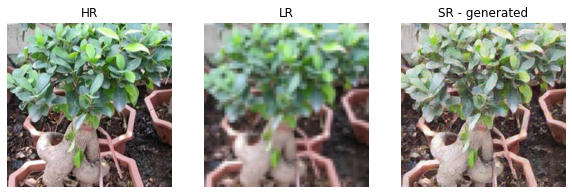

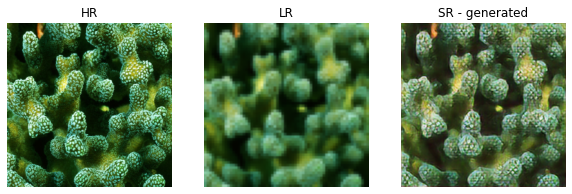

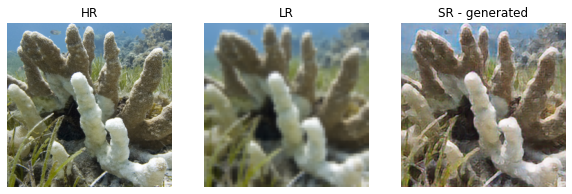

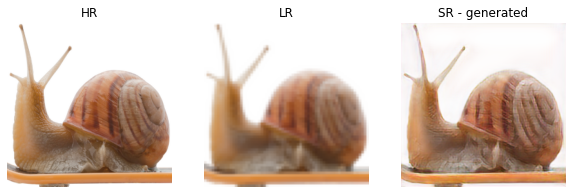

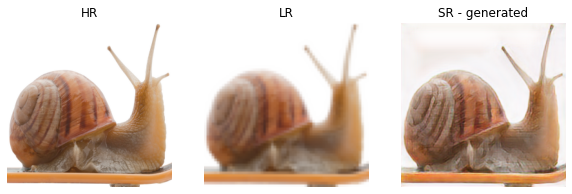

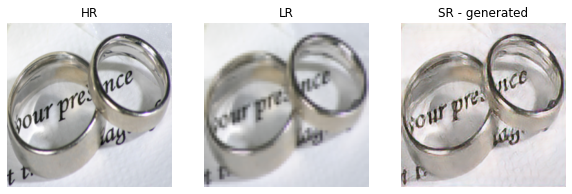

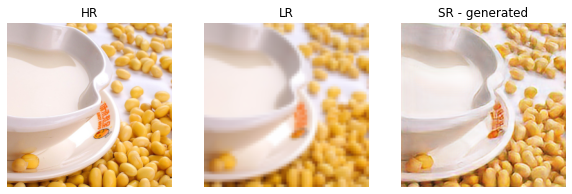

In [50]:
# training loop

for epoch in range(epochs):

    d_history = []
    g_history = []
    
    image_list = get_train_images(data_path)
    
    """
    Train the discriminator network
    """
    
    hr_images, lr_images = sample_images(image_list, 
                                         batch_size=batch_size,
                                         low_resolution_shape=low_resolution_shape,
                                         high_resolution_shape=high_resolution_shape)
    
    
    # normalize the images
    hr_images = hr_images / 127.5 - 1.
    lr_images = lr_images / 127.5 - 1.
    
    # generate high-resolution images from low-resolution images
    generated_high_resolution_images = generator.predict(lr_images)
    
    # generate a batch of true and fake labels 
    real_labels = np.ones((batch_size, 16, 16, 1))
    fake_labels = np.zeros((batch_size, 16, 16, 1))
    
 
    d_loss_real = discriminator.train_on_batch(hr_images, real_labels)
    d_loss_real =  np.mean(d_loss_real)
    d_loss_fake = discriminator.train_on_batch(generated_high_resolution_images, fake_labels)
    d_loss_fake =  np.mean(d_loss_fake)
    
    # calculate total loss of discriminator as average loss on true and fake labels
    d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)
    losses['d_history'].append(d_loss)
   

    """
        Train the generator network
    """
      
    # sample a batch of images    
    hr_images, lr_images = sample_images(image_list, 
                                         batch_size=batch_size,
                                         low_resolution_shape=low_resolution_shape,
                                         high_resolution_shape=high_resolution_shape)
    
    
    # normalize the images
    hr_images = hr_images / 127.5 - 1.
    lr_images = lr_images / 127.5 - 1.
    
    
    
    # extract feature maps for true high-resolution images
    image_features = fe_model.predict(hr_images)


    
    # train the generator
    g_loss = adversarial_model.train_on_batch([lr_images, hr_images],
                                               [real_labels, image_features])
    
    losses['g_history'].append(0.5 * (g_loss[1]))
    
    
    
    # calculate the psnr  
    ps = compute_psnr(hr_images, generated_high_resolution_images) 
    psnr['psnr_quality'].append(ps)
            
    # calculate the ssim 
    ss = compute_ssim(hr_images, generated_high_resolution_images)   
    ssim['ssim_quality'].append(ss)

    
  
    """
        save and print image samples
    """
    
    if epoch % 500 == 0:
        
        hr_images, lr_images = sample_images(image_list, 
                                             batch_size=batch_size,
                                             low_resolution_shape=low_resolution_shape,
                                             high_resolution_shape=high_resolution_shape)
    
    
        # normalize the images
        hr_images = hr_images / 127.5 - 1.
        lr_images = lr_images / 127.5 - 1.
    
    
        generated_images = generator.predict_on_batch(lr_images)
    
        for index, img in enumerate(generated_images):
            if index < 3:   # comment this line to display all the images
                save_images(hr_images[index], lr_images[index], img,
                            path="/content/tempimg/img_{}_{}".format(epoch, index))  
                        

In [22]:
mkdir 'tempimg'

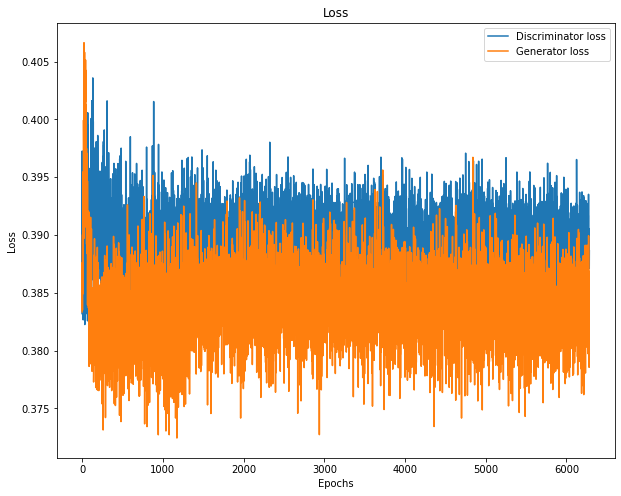

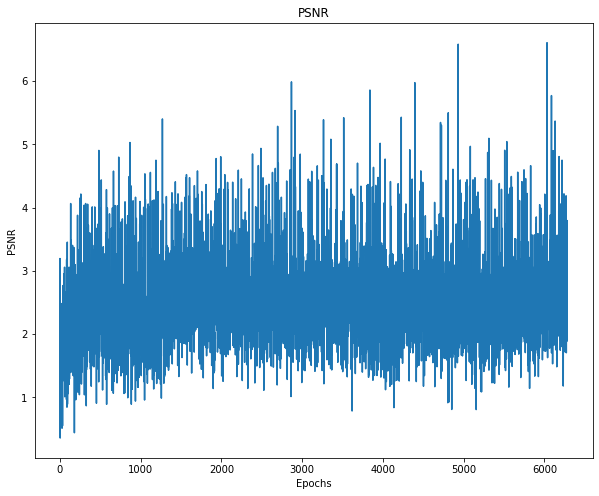

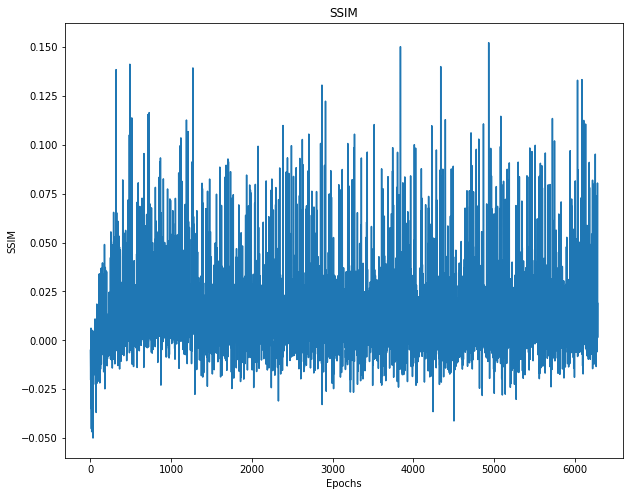

In [52]:
# plots - post training

plot_loss(losses)
plot_psnr(psnr)
plot_ssim(ssim)

In [193]:
# generator.save_weights("/content/drive/MyDrive/SRCNN_Data/GAN_Models/srgan_generator.h5")
# discriminator.save_weights("/content/drive/MyDrive/SRCNN_Data/GAN_Models/srgan_discriminator.h5")
# import h5py
# with h5py.File('srgan_generator.h5', 'w') as h:
#     h.save_weights("/content/drive/MyDrive/SRCNN_Data/GAN_Models/srgan_generator.h5")

from tensorflow.keras.models import model_from_json
from keras.models import load_model

# serialize model to JSON
#  the keras model which is trained is defined as 'model' in this example
model_json = generator.to_json()

with open("generator_json.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
generator.save_weights("srgan_generator_model.h5")


In [194]:
from tensorflow.keras.models import model_from_json
from keras.models import load_model

# serialize model to JSON
#  the keras model which is trained is defined as 'model' in this example
model_json = generator.to_json()

with open("/content/drive/MyDrive/SRCNN_Data/Final/GAN_Models/generator_json.json", "w") as json_file:
    json_file.write(model_json)

# serialize weights to HDF5
generator.save_weights("/content/drive/MyDrive/SRCNN_Data/Final/GAN_Models/srgan_generator_model_weight.h5")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


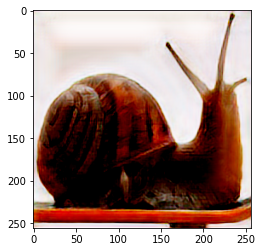

In [63]:
plt.imshow(lr_images[1])
plt.imshow(generated_images[0])

In [64]:
# im = generator.predict(lr_images[1])
generator.summary()

Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_46 (Conv2D)              (None, 64, 64, 64)   15616       input_8[0][0]                    
__________________________________________________________________________________________________
conv2d_47 (Conv2D)              (None, 64, 64, 64)   36928       conv2d_46[0][0]                  
__________________________________________________________________________________________________
activation_20 (Activation)      (None, 64, 64, 64)   0           conv2d_47[0][0]                  
__________________________________________________________________________________________

In [113]:
image_list = get_train_images(data_path)   
hr_images, lr_images = sample_images(image_list, 
                                    batch_size=75,
                                    low_resolution_shape=low_resolution_shape,
                                    high_resolution_shape=high_resolution_shape)


# normalize the images
hr_images = hr_images / 127.5 - 1.
lr_images = lr_images / 127.5 - 1.

# generate high-resolution images from low-resolution images
generated_high_resolution_images = generator.predict(lr_images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


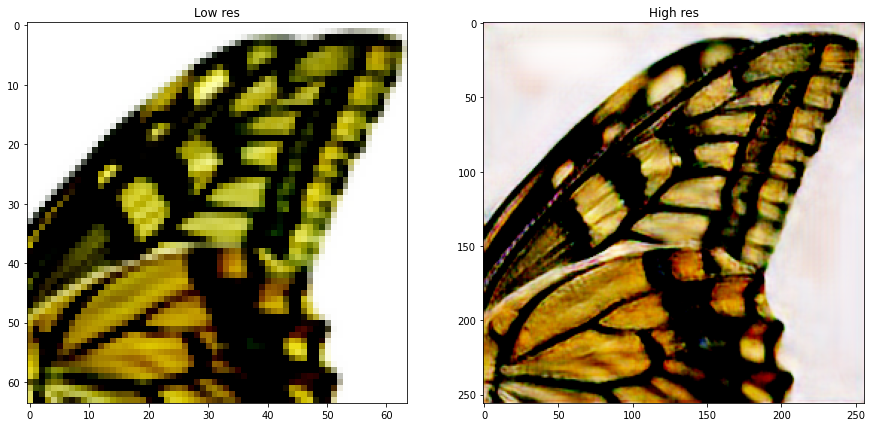

In [129]:
from PIL import Image

index = 28

fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(lr_images[index])
ax[0].title.set_text('Low res')
ax[1].imshow(generated_high_resolution_images[index])
ax[1].title.set_text('High res')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


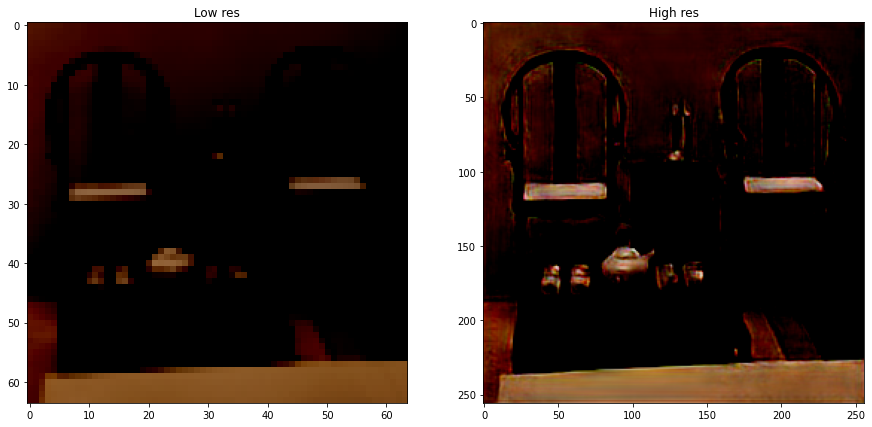

In [131]:
from PIL import Image

index = 57

fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(lr_images[index])
ax[0].title.set_text('Low res')
ax[1].imshow(generated_high_resolution_images[index])
ax[1].title.set_text('High res')
plt.show()

In [195]:
generator.save("/content/drive/MyDrive/SRCNN_Data/Final/GAN_Models/Generator.h5")

In [196]:
discriminator.save("/content/drive/MyDrive/SRCNN_Data/Final/GAN_Models/Discriminator.h5")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


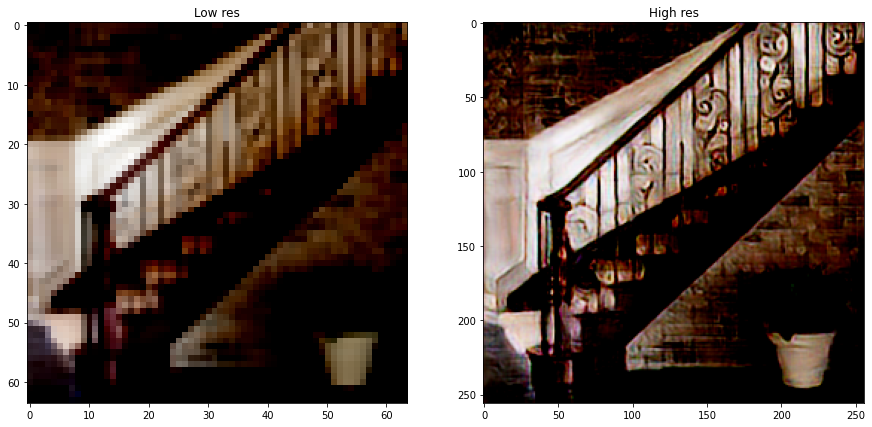

In [150]:
from PIL import Image

index = 19

fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(lr_images[index])
ax[0].title.set_text('Low res')
ax[1].imshow(generated_high_resolution_images[index])
ax[1].title.set_text('High res')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


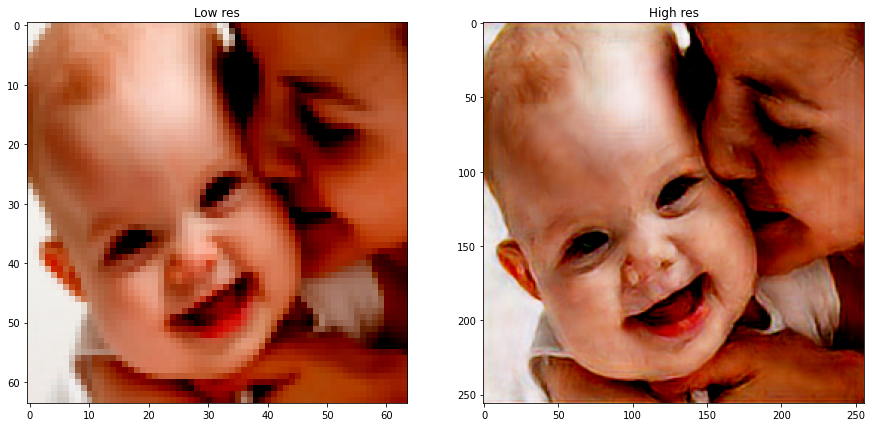

In [169]:
from PIL import Image

index = 38

fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(lr_images[index])
ax[0].title.set_text('Low res')
ax[1].imshow(generated_high_resolution_images[index])
ax[1].title.set_text('High res')
plt.show()

In [179]:
from tensorflow.keras.models import load_model
# new_model = load_model('gen_model.h5',custom_objects={'SubpixelConv2D': SubpixelConv2D()})
# new_model = get_G((96, 96, 3))
# new_model.summary()
new_model = load_model('Generator.h5')

In [180]:
new_model = build_generator()

In [181]:
image_list = get_train_images(TEST_PATH)   
hr_images, lr_images = sample_images(image_list, 
                                    batch_size=20,
                                    low_resolution_shape=low_resolution_shape,
                                    high_resolution_shape=high_resolution_shape)


# normalize the images
hr_images = hr_images / 127.5 - 1.
lr_images = lr_images / 127.5 - 1.

# generate high-resolution images from low-resolution images
generated_high_resolution_images = new_model.predict(lr_images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


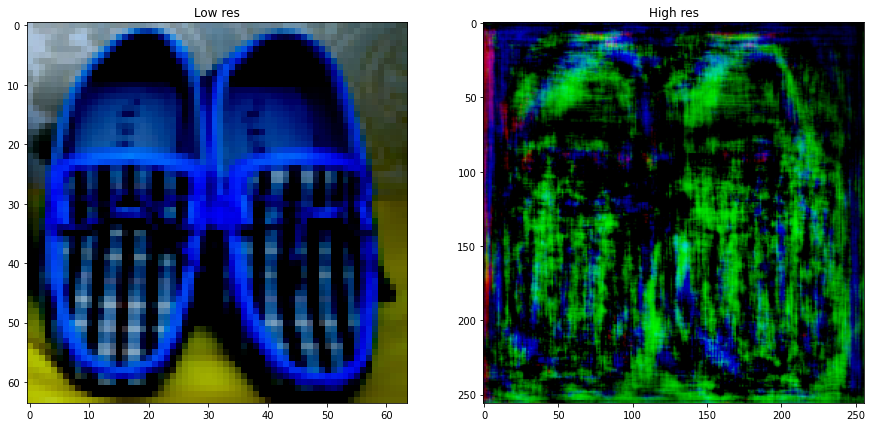

In [182]:
index = 4

fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(lr_images[index])
ax[0].title.set_text('Low res')
ax[1].imshow(generated_high_resolution_images[index])
ax[1].title.set_text('High res')
plt.show()

In [183]:
# input_low_resolution = Input(shape=low_resolution_shape)

# # generate high-resolution images from low-resolution images
# generated_high_resolution_images = generator(input_low_resolution)

new_model.summary()

Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_16 (InputLayer)           (None, 64, 64, 3)    0                                            
__________________________________________________________________________________________________
conv2d_165 (Conv2D)             (None, 64, 64, 64)   15616       input_16[0][0]                   
__________________________________________________________________________________________________
conv2d_166 (Conv2D)             (None, 64, 64, 64)   36928       conv2d_165[0][0]                 
__________________________________________________________________________________________________
activation_77 (Activation)      (None, 64, 64, 64)   0           conv2d_166[0][0]                 
__________________________________________________________________________________________

In [188]:
# load json and create model
json_file = open('model_num.json', 'r')

loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("srgan_generator.h5")
print("Loaded model from disk")

Loaded model from disk


In [189]:
loaded_model.summary()

Model: "generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 64, 64, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_46 (Conv2D)              (None, 64, 64, 64)   15616       input_8[0][0]                    
__________________________________________________________________________________________________
conv2d_47 (Conv2D)              (None, 64, 64, 64)   36928       conv2d_46[0][0]                  
__________________________________________________________________________________________________
activation_20 (Activation)      (None, 64, 64, 64)   0           conv2d_47[0][0]                  
__________________________________________________________________________________________

In [190]:
image_list = get_train_images(TEST_PATH)   
hr_images, lr_images = sample_images(image_list, 
                                    batch_size=7,
                                    low_resolution_shape=low_resolution_shape,
                                    high_resolution_shape=high_resolution_shape)


# normalize the images
hr_images = hr_images / 127.5 - 1.
lr_images = lr_images / 127.5 - 1.

# generate high-resolution images from low-resolution images
generated_high_resolution_images = loaded_model.predict(lr_images)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


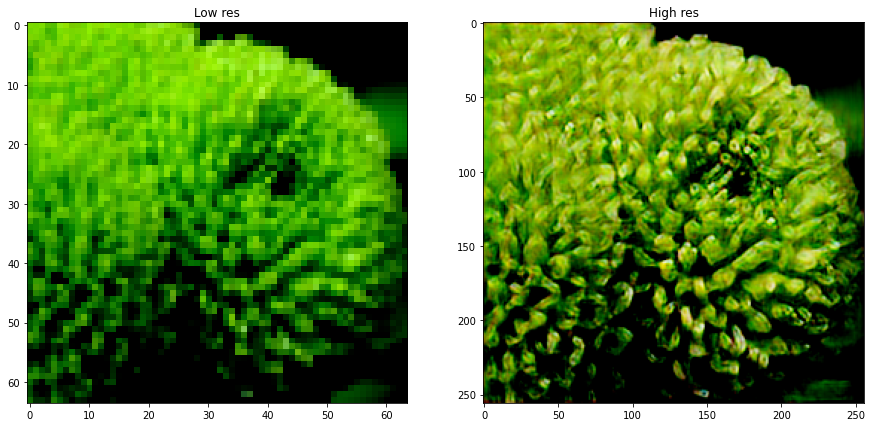

In [192]:
index = 5

fig, ax = plt.subplots(1, 2, figsize=(15, 10))
ax[0].imshow(lr_images[index])
ax[0].title.set_text('Low res')
ax[1].imshow(generated_high_resolution_images[index])
ax[1].title.set_text('High res')
plt.show()